In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# data description 
from data_des_ import data_des
#encoder
from sklearn.preprocessing import LabelEncoder , OrdinalEncoder , OneHotEncoder
#split
from sklearn.model_selection import train_test_split
# score
from sklearn.metrics import accuracy_score
# for the warning 
import warnings
warnings.filterwarnings('ignore')


# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

# PCA
from sklearn.decomposition import PCA

#Grid Search
from sklearn.model_selection import GridSearchCV

#confusion matrix
from sklearn.metrics import plot_confusion_matrix
# Select K best
from sklearn.feature_selection import SelectKBest, chi2

# Model's Algorthims
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


In [2]:
# read the data
df = pd.read_csv("../Data/cleaned.csv")

In [3]:
# make a copy of the data
df_copy = df.copy()

In [4]:
# Split the data
X_train, X_test = train_test_split(df_copy, 
                                   test_size = 0.20, 
                                   random_state = 42)

In [5]:
# take these columns to use one hot encoder later on it 
categoricalcols=['gender','age','education','connection_type','new_major','regions','PC_OS','phone_OS','future_feeling_CC']


In [6]:
#label encoder
# take the column's names that we wanted to do the label encoder on them
last_15_columns_names = [column_name for column_name in X_train.columns]

### Label Encoder

In [7]:
# LabelEncoder #7
le = LabelEncoder()


# take each column name and encoded except the target will map it
for col_name in last_15_columns_names:
    # target
    if col_name == "victim":
        X_train[col_name] = X_train[col_name].map({'Yes': 1, 'No': 0})
        X_test[col_name] = X_test[col_name].map({'Yes': 1, 'No': 0})
    elif (col_name == "freq_used") | (col_name == "used_purpose") | (col_name == "security_apps") \
            | (col_name == "Internet_security") | (col_name == "updated_about_CC_(offline Sources)") \
            | (col_name == "updated_about_CC(_Online Sources)") | (col_name == "major")\
            | (col_name == "regoins") | ((col_name in categoricalcols) == True) :
        pass

    else:
        X_train[col_name] = le.fit_transform(X_train[col_name])
        X_test[col_name] = le.transform(X_test[col_name])



### One Hot Encoder

In [8]:
# here using the one hot encoder 
one_hot = OneHotEncoder()

# One Hot encode the column
one_hot_df = one_hot.fit_transform(X_train[categoricalcols]).toarray()
one_hot_df_test = one_hot.transform(X_test[categoricalcols]).toarray()
#Column names
column_names = []
for y in range(len(one_hot.categories_)):
    for z in range(len(one_hot.categories_[y])):
        column_names.append(categoricalcols[y]+"_"+one_hot.categories_[y][z])
#Turn Encoded data into a df and add column names
oh_df = pd.DataFrame(
    one_hot_df,
    index=X_train.index,
    columns = column_names
)
oh_df_test = pd.DataFrame(
    one_hot_df_test,
    index=X_test.index,
    columns = column_names
)
#Merge one hot encoded df to train and test dfs 
X_train = X_train.merge( oh_df, on=X_train.index).set_index("key_0").drop(categoricalcols, axis=1)
X_test = X_test.merge(oh_df_test, on=X_test.index).set_index("key_0").drop(categoricalcols, axis=1)


In [9]:
## split to x and y 
y_train=X_train['victim']
X_train = X_train.drop(["victim","freq_used","major" ,"Internet_security","used_purpose","security_apps","updated_about_CC_(offline Sources)","updated_about_CC(_Online Sources)","not_victim_would_like_to_report","new_ragions"], axis = 1)

y_test=X_test['victim']
X_test = X_test.drop(["victim","freq_used","major" ,"Internet_security","used_purpose","security_apps", "updated_about_CC_(offline Sources)","updated_about_CC(_Online Sources)","not_victim_would_like_to_report","new_ragions"], axis = 1)

### BaseLine

In [10]:
##### This is the baseline 
y_train.value_counts(normalize=True)

0    0.770732
1    0.229268
Name: victim, dtype: float64

### Logistic Regression

In [11]:
# Create a Pipeline and create PCA
pipe_with_pca_lr = make_pipeline(
#     PCA(),
    SelectKBest(score_func=chi2),
    LogisticRegression()
)

In [12]:
#GridSearchCV
param_grid = {
    "selectkbest__k": list(range(1,84,3)),
#     "pca__n_components": [0.7,0.8,0.85,0.9,0.95], # all components explains the most variance
    "logisticregression__C": [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1],
    "logisticregression__max_iter": [1,2,4,6,8,10],
    "logisticregression__random_state" : [42],
}

gridlr = GridSearchCV(
    pipe_with_pca_lr, 
    param_grid=param_grid, 
    cv=10, 
    verbose=1, # Higher number means the training step show more output
    n_jobs=-1 # Use all available cores on my computer 
)

gridlr.fit(X_train,y_train)

Fitting 10 folds for each of 1680 candidates, totalling 16800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 664 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 2664 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 5464 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 9064 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 13464 tasks      | elapsed:   45.5s
[Parallel(n_jobs=-1)]: Done 16800 out of 16800 | elapsed:   54.9s finished


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('selectkbest',
                                        SelectKBest(score_func=<function chi2 at 0x7fa5389645e0>)),
                                       ('logisticregression',
                                        LogisticRegression())]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [1, 0.9, 0.8, 0.7, 0.6, 0.5,
                                                   0.4, 0.3, 0.2, 0.1],
                         'logisticregression__max_iter': [1, 2, 4, 6, 8, 10],
                         'logisticregression__random_state': [42],
                         'selectkbest__k': [1, 4, 7, 10, 13, 16, 19, 22, 25, 28,
                                            31, 34, 37, 40, 43, 46, 49, 52, 55,
                                            58, 61, 64, 67, 70, 73, 76, 79,
                                            82]},
             verbose=1)

In [13]:
# Best Parameters
gridlr.best_params_

{'logisticregression__C': 1,
 'logisticregression__max_iter': 4,
 'logisticregression__random_state': 42,
 'selectkbest__k': 10}

In [14]:
gridlr.best_score_

0.771951219512195

In [15]:
preds_lr = gridlr.predict(X_test)
accuracy_score(y_test, preds_lr)

0.824390243902439

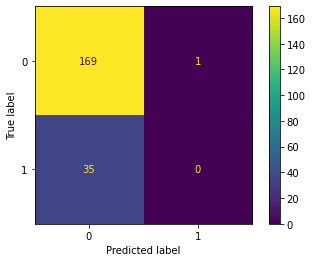

In [16]:
plot_confusion_matrix(gridlr, X_test, y_test)
plt.grid(False);

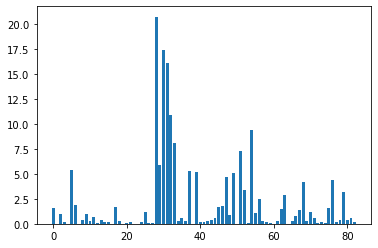

In [17]:
# for i in range(len(gridlr.best_estimator_.named_steps['selectkbest'].scores_)):
#     print('Feature %d: %f' % (i, gridlr.best_estimator_.named_steps['selectkbest'].scores_[i]))
# here to see the best features for this model  
plt.bar([i for i in range(len(gridlr.best_estimator_.named_steps['selectkbest'].scores_))], gridlr.best_estimator_.named_steps['selectkbest'].scores_)
plt.show()

### DecisionTreeClassifier

In [18]:
# Create a Pipeline and create PCA
pipe_with_pca_dt = make_pipeline(
#     PCA(),
    SelectKBest(chi2),
    DecisionTreeClassifier()
)

In [19]:
param_grid_dt = {
#     "pca__n_components": list(range(1,84)), # all components explains the most variance
    'selectkbest__k':list(range(10,20)) ,
    "decisiontreeclassifier__criterion": ['entropy', 'gini'],
    "decisiontreeclassifier__splitter": ["best", "random"],
    "decisiontreeclassifier__max_depth": [None,1,2,3,5,6,7,8,9,10],
    "decisiontreeclassifier__ccp_alpha": [0.0,0.030],
    "decisiontreeclassifier__random_state" : [42],
}

griddt = GridSearchCV(
    pipe_with_pca_dt, # model
    param_grid_dt, # hyperparameter to tune
    cv = 15, # K-fold cross validation
    n_jobs=-1, # use all cores on cpu
    verbose=1 # show output
)

griddt.fit(X_train, y_train)

Fitting 15 folds for each of 800 candidates, totalling 12000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 2568 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 5368 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 8968 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 12000 out of 12000 | elapsed:   24.2s finished


GridSearchCV(cv=15,
             estimator=Pipeline(steps=[('selectkbest',
                                        SelectKBest(score_func=<function chi2 at 0x7fa5389645e0>)),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid={'decisiontreeclassifier__ccp_alpha': [0.0, 0.03],
                         'decisiontreeclassifier__criterion': ['entropy',
                                                               'gini'],
                         'decisiontreeclassifier__max_depth': [None, 1, 2, 3, 5,
                                                               6, 7, 8, 9, 10],
                         'decisiontreeclassifier__random_state': [42],
                         'decisiontreeclassifier__splitter': ['best', 'random'],
                         'selectkbest__k': [10, 11, 12, 13, 14, 15, 16, 17, 18,
                                            19]},
  

In [20]:
griddt.best_params_

{'decisiontreeclassifier__ccp_alpha': 0.0,
 'decisiontreeclassifier__criterion': 'entropy',
 'decisiontreeclassifier__max_depth': 3,
 'decisiontreeclassifier__random_state': 42,
 'decisiontreeclassifier__splitter': 'random',
 'selectkbest__k': 12}

In [21]:
griddt.best_score_

0.7744781144781145

In [22]:
preds_dt = griddt.predict(X_test)
accuracy_score(y_test, preds_dt)

0.824390243902439

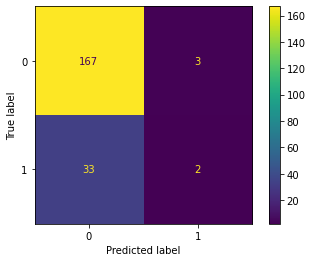

In [23]:
plot_confusion_matrix(griddt, X_test, y_test)
plt.grid(False);

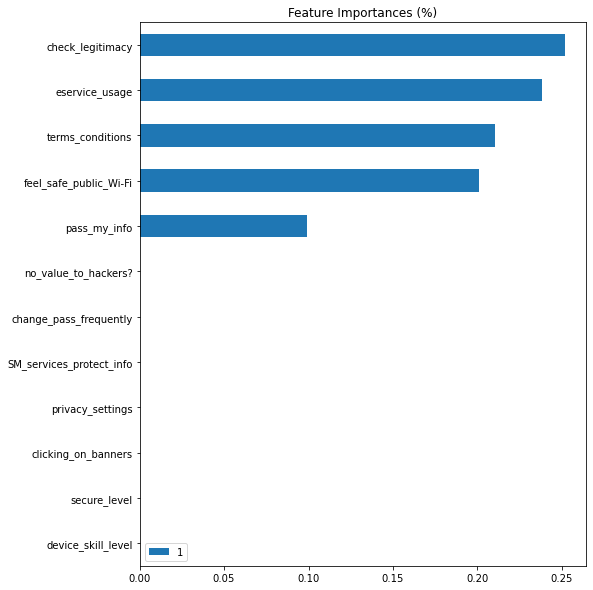

In [24]:
# see the importance of each columns in the model 
pd.DataFrame(dict(zip(X_train.columns, griddt.best_estimator_.named_steps['decisiontreeclassifier'].feature_importances_)), index = [1])\
.T\
.sort_values(1, ascending=True)\
.plot(kind="barh", title="Feature Importances (%)", figsize=(8, 10));


### RandomForestClassifier

In [25]:
# Create a Pipeline and create PCA
pipe_with_pca_rf = make_pipeline(
    PCA(),
#     SelectKBest(score_func=chi2),
    RandomForestClassifier()
)

In [26]:
param_grid_rf = {
     "pca__n_components": [0.3,0.4,0.45,0.5,0.52], 
#     "selectkbest__k": list(range(1,30,2)),
    "randomforestclassifier__n_estimators": [100,200,300,400,500,600,700,800,900], # how many trees in our forest
    "randomforestclassifier__criterion": ["gini", "entropy"], # what criteria is used to split nodes 
    "randomforestclassifier__random_state" : [42],
}

grid_rf = GridSearchCV(
    pipe_with_pca_rf, # model
    param_grid_rf, # hyperparameter to tune
    cv = 5, # K-fold cross validation
    n_jobs=-1, # use all cores on cpu
    verbose=1 # show output
)

grid_rf.fit(X_train, y_train)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   48.4s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:  2.2min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pca', PCA()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'pca__n_components': [0.3, 0.4, 0.45, 0.5, 0.52],
                         'randomforestclassifier__criterion': ['gini',
                                                               'entropy'],
                         'randomforestclassifier__n_estimators': [100, 200, 300,
                                                                  400, 500, 600,
                                                                  700, 800,
                                                                  900],
                         'randomforestclassifier__random_state': [42]},
             verbose=1)

In [27]:
# Best Parameters
grid_rf.best_params_

{'pca__n_components': 0.52,
 'randomforestclassifier__criterion': 'gini',
 'randomforestclassifier__n_estimators': 100,
 'randomforestclassifier__random_state': 42}

In [28]:
grid_rf.best_params_

{'pca__n_components': 0.52,
 'randomforestclassifier__criterion': 'gini',
 'randomforestclassifier__n_estimators': 100,
 'randomforestclassifier__random_state': 42}

In [29]:
grid_rf.best_score_

0.7695121951219512

In [30]:
preds_rf = grid_rf.predict(X_test)
accuracy_score(y_test, preds_rf)

0.8146341463414634

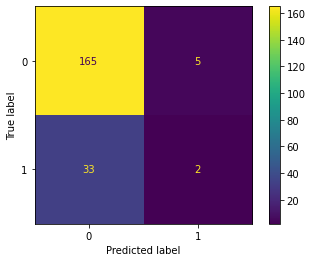

In [31]:
plot_confusion_matrix(grid_rf, X_test, y_test)
plt.grid(False);

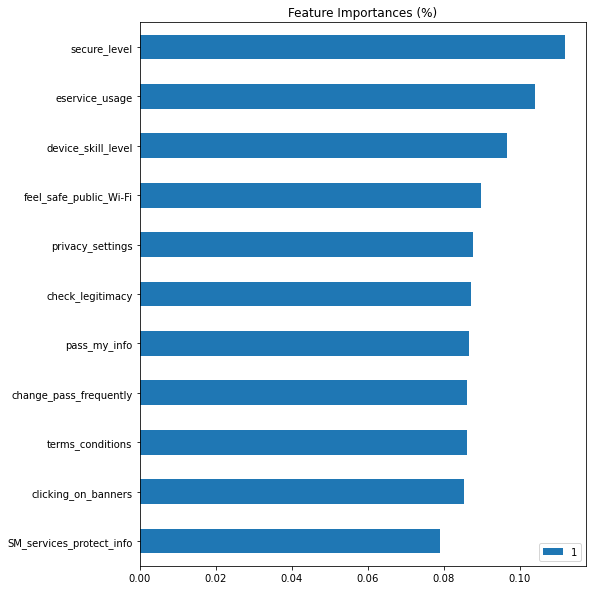

In [32]:
# see the importance of each columns in the model 
pd.DataFrame(dict(zip(X_train.columns, grid_rf.best_estimator_.named_steps['randomforestclassifier'].feature_importances_)), index = [1])\
.T\
.sort_values(1, ascending=True)\
.plot(kind="barh", title="Feature Importances (%)", figsize=(8, 10));

### SVC

In [33]:
# svc 
# Create a Pipeline and create PCA
pipe_with_pca_svc = make_pipeline(
#     PCA(),
    SelectKBest(score_func=chi2),
    SVC()
)

In [34]:
param_grid_svc = {
#     "pca__n_components": [0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.85,0.9], 
    "selectkbest__k": list(range(2,84,2)),
    "svc__kernel": ["linear","poly"], # how many trees in our forest
    "svc__random_state" : [42],
}

grid_svc = GridSearchCV(
    pipe_with_pca_svc, # model
    param_grid_svc, # hyperparameter to tune
    cv = 5, # K-fold cross validation
    n_jobs=-1, # use all cores on cpu
    verbose=1 # show output
)

grid_svc.fit(X_train, y_train)

Fitting 5 folds for each of 82 candidates, totalling 410 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 410 out of 410 | elapsed:    4.3s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('selectkbest',
                                        SelectKBest(score_func=<function chi2 at 0x7fa5389645e0>)),
                                       ('svc', SVC())]),
             n_jobs=-1,
             param_grid={'selectkbest__k': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20,
                                            22, 24, 26, 28, 30, 32, 34, 36, 38,
                                            40, 42, 44, 46, 48, 50, 52, 54, 56,
                                            58, 60, ...],
                         'svc__kernel': ['linear', 'poly'],
                         'svc__random_state': [42]},
             verbose=1)

In [35]:
# Best Parameters
grid_svc.best_params_

{'selectkbest__k': 40, 'svc__kernel': 'poly', 'svc__random_state': 42}

In [36]:
grid_svc.best_score_

0.7731707317073171

In [37]:
preds_svc = grid_svc.predict(X_test)
accuracy_score(y_test, preds_svc)

0.824390243902439

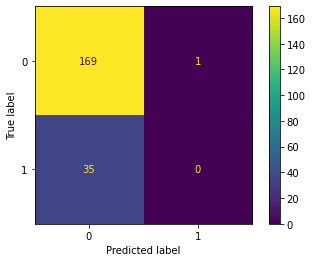

In [38]:
plot_confusion_matrix(grid_svc, X_test, y_test)
plt.grid(False);

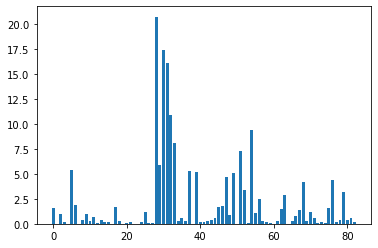

In [39]:
# for i in range(len(grid_svc.best_estimator_.named_steps['selectkbest'].scores_)):
#     print('Feature %d: %f' % (i, grid_svc.best_estimator_.named_steps['selectkbest'].scores_[i]))
# plot the scores
plt.bar([i for i in range(len(grid_svc.best_estimator_.named_steps['selectkbest'].scores_))], grid_svc.best_estimator_.named_steps['selectkbest'].scores_)
plt.show()

### Conclusion

In [40]:
def models_results(lr,dt,rf,svc):
    print(f"BaseLine : {y_train.value_counts(normalize=True)[0]}")
    print(f"Logistic Regression : {accuracy_score(y_test, preds_lr)}")
    print(f"Decision Tree Classifier : {accuracy_score(y_test, preds_dt)}")
    print(f"Random Forest Classifier : {accuracy_score(y_test, preds_rf)}")
    print(f"SVC : {accuracy_score(y_test, preds_svc)}")

In [41]:
# we see the best model is Random Forest Classifier because it use as less as possible 
# for the features and give as a great result.
models_results(preds_lr,preds_dt,preds_rf,preds_svc)

BaseLine : 0.7707317073170732
Logistic Regression : 0.824390243902439
Decision Tree Classifier : 0.824390243902439
Random Forest Classifier : 0.8146341463414634
SVC : 0.824390243902439
